In [1]:
import Yukawa_SINDy as ys
import Yukawa3body as y3
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
from tabulate import tabulate
from importlib import reload

In [78]:
# reload modules if needed
reload(ys)
reload(y3)

<module 'Yukawa3body' from 'c:\\Users\\zacha\\Box\\Graduate School\\Research\\Code\\Yukawa3body.py'>

# Noise analysis for 3-body Yukawa system

Here, we load in the data used for all the noise cases used in this notebook. The data is a list of 200 `y3.Yukawa3body` objects with *no noise added*, and the data is *unsubtracted*.

In [4]:
# load in data
sim_list = y3.load_data('data/solve_ivp simulation/basic_noisy/analysis_trajectories')

In [ ]:
sim_list[0].x

array([[-0.16900174,  9.77856559,  0.03616896, ..., -8.69298223,
        -0.08168847,  4.94287973],
       [-0.16802416,  9.77304626,  0.0359598 , ..., -8.68971506,
        -0.08119424,  4.94174506],
       [-0.16704713,  9.76748705,  0.03575087, ..., -8.68639567,
        -0.08070012,  4.94058513],
       ...,
       [ 0.30553145,  3.7097691 ,  0.66950372, ..., -4.47992261,
        -0.61920196, -7.69547494],
       [ 0.30590242,  3.70960875,  0.67033948, ..., -4.47994542,
        -0.61997151, -7.69550843],
       [ 0.30627337,  3.70944878,  0.67117524, ..., -4.47996814,
        -0.62074106, -7.6955418 ]])

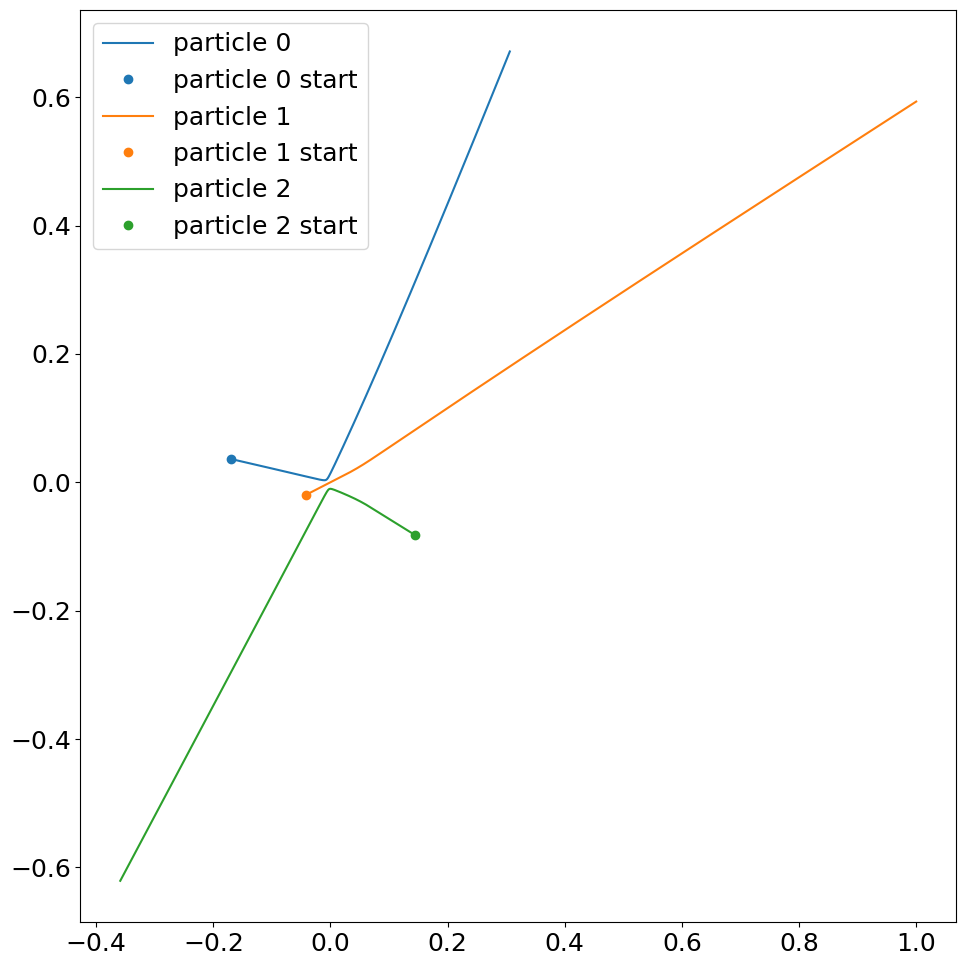

In [10]:
sim_list[0].plot()

## Data magnitude analysis

In [5]:
sim_list[0].x.shape

(1001, 12)

We can concatenate all the data into one list and find the average magnitude in order to decide how to add noise to the data. If we truly do *all* the data however, which includes both positions and velocities, an average doesn't mean much because generally the positions and velocities do not have the same order of magnitude. Thus we can get a sense for the magnitudes of the differences in positions and velocities by taking the absolute value and averaging them separately.

In [ ]:
all_data = np.concatenate([sim.x for sim in sim_list])
all_positions = np.concatenate([position for position in all_data[:,0::2]])
all_velocities = np.concatenate([velocity for velocity in all_data[:,1::2]])
avg_abs_position = np.average(np.abs(all_positions))
avg_abs_velocity = np.average(np.abs(all_velocities))
avgs = [
    ["average magnitude of interparticle spacings:", avg_abs_position],
    ["average magnitude of differences in velocity:", avg_abs_velocity]
]
print(tabulate(avgs))

We can get a sense for the spread of the data by computing the minima, maxima, and standard deviations of the position and velocity data.

In [ ]:
spread_stuff = [
    ["maximum interparticle spacing:", np.max(all_positions)],
    ["minimum interparticle spacing:", np.min(all_positions)],
    ["std. dev. of interparticle spacings:", np.std(all_positions)],
    ["maximum diff. in velocity:", np.max(all_velocities)],
    ["minimum diff. in velocity:", np.min(all_velocities)],
    ["std. dev. of diffs. in velocity:", np.std(all_velocities)]
]
print(tabulate(spread_stuff))

Could also get a sense for the scale of the data by looking at the l2 norm of the data, which can be done as follows:

In [ ]:
import sklearn
zeros = np.zeros_like(all_positions)
sklearn.metrics.root_mean_squared_error(zeros, all_positions)

In [ ]:
sklearn.metrics.root_mean_squared_error(zeros, all_velocities)

We can extract the simulation parameters used in this set by taking a look at the object attributes from the first element.

In [ ]:
# print simulation parameters
print("Number of trajectories:", len(sim_list))
print("Timestep duration:", sim_list[0].dt)
print("Duration:", sim_list[0].duration)
print("Number of timesteps (sanity check):", sim_list[0].x.shape[0])
print("Number of features (sanity check):", sim_list[0].x.shape[1])
print("Noisy:", sim_list[0].is_noisy)
print("Subtracted:", sim_list[0].is_subtracted)

Below is some code that will generate plots of 9 of the trajectories *with noise added*. 

In [ ]:
for sim in sim_list:
    if sim.is_noisy:
        sim.delete_noise()
    sim.add_gaussian_noise(noise_level=1e-4)

In [ ]:
y3.plot_multiple(sim_list[190:])

## Strong-form SINDy

### `noise_level = 0`

We begin by looking at the clean data, with no Gaussian noise added. SINDy models were generated using the python script 'Code/data/basic_sindy_results_noisy.py'.

In [7]:
# load in SINDy models for 0 noise case
nonoise_models = y3.load_SINDy_models('data/basic_noisy/SINDy_results/noise_0.00000/model_objs')
# remove models with threshold > 1 from list
nonoise_models = [model for model in nonoise_models if model.optimizer.threshold <= 1]

In [ ]:
ys.plot_complexity_objs(nonoise_models)

- course-graining (threshold scan from 0 to 0.45, increment 0.05) shows that the correct model is discovered some point between 0.3 and 0.35.
- I want to find the transition point from bad to good model to 3 significant figures, so I then did a more fine step of 0.005 and found that the discovered model becomes correct between 0.330 and 0.335
- Finally, investigating  between 0.328 and 0.337 by steps of 0.001 we find the critical threshold to be 0.334.
- This is not reflected in the plot above, which was made later.

First, we can look to see where the $\dot{v}$-equations are fit. It actually happens very early on while stepping through different thresholds. In fact, by `threshold=0.02`, all the interesting equations of motion ($\dot{v}$-equations) are fit accurately and the trivial relations of $\dot{x}=v$ are massively overfit.

In [ ]:
for i in [0,1,2]:
    y3.print_SINDy_nice(nonoise_models[i], sim_list)

Next we look at the "critical threshold," where the known model is discovered. Below are the models for `threshold=0.330` and `threshold=0.340`. We can see that in the 0.330 case, all of the trivial equations (of the form $\dot{x}=v$) are characterized by extremely large coefficients ($\sim 10^6$) for all the velocity features available to them *that are in the correct cartesian direction*. For example, the `(y0-y1)'`-equation has all 6 velocity features (of the form `(vxi-vxj)` and `(vyi-vyj)` for $i,j\in\{0,1,2|i\neq j\}$). On the other hand, the interesting equations (of the form $\dot{v}=f(x)$) are "correctly" discovered.

In [ ]:
for i in [33,34]:
    y3.print_SINDy_nice(nonoise_models[i], sim_list)

### `noise_level = 1e-5`

In [8]:
noise00001_models = y3.load_SINDy_models('data/basic_noisy/SINDy_results/noise_0.00001/model_objs')

- The approximately correct model is discovered with a threshold of 0.40, where we only stepped the solver with 0.01 resolution.
- The complexity vs. threshold plot is shown here:

In [ ]:
ys.plot_complexity_objs(noise00001_models)

here, we see a similar trend to the no-noise case, in which the complicated, $\dot{v}$-equations are fit first, followed by the the trivial $\dot{x}=v$ equations.

In [ ]:
for i in [21,22]:
    y3.print_SINDy_nice(noise00001_models[i], sim_list)

We can look at the models around 0.4 to see how they evolve to the correct model.

In [ ]:
for i in [39,40]:
    y3.print_SINDy_nice(noise00001_models[i], sim_list)

- As we can see above, the only equation that is wrong with `threshold=0.39` is the `(y1-y2)'` equation, which proves to be an issue later as well (see below).
- It could be interesting to investigate whether that is a problem with this particular set of trajectories. There is no obvious reason why that particular equation would be an issue.

### `noise_level = 2e-5`

In [9]:
noise00002_models = y3.load_SINDy_models('data/basic_noisy/SINDy_results/noise_0.00002/model_objs')
noise00002_models = [model for model in noise00002_models if model.optimizer.threshold <= 1]

In [ ]:
ys.plot_complexity_objs(noise00002_models)

- Interestingly, the steps here are much more small and incremental than in the no noise case
- Here, the correct model is *not* discovered. We can check around the correct complexity value and see how close we get.
- The model generated with threshold=0.64 comes the closest to the true model without zeroing out any coefficients shown below

In [ ]:
for i in [40,50]:
    y3.print_SINDy_nice(noise00002_models[i], sim_list)

In [ ]:
for i in [57,58,60]:
    y3.print_SINDy_nice(noise00002_models[i], sim_list)

- In all three cases shown here, we can see that the `(vx1-vx2)'` equation contains extraneous terms with very large coefficients
- In the first case with `threshold=0.57` we can see that there are no equations in which all the coefficients are zero. Problematic equations are only the `(vx1-vx2)'` equation, the `(y1-y2)'` equation, and the `(vy2-vy0)` equation which contain extraneous terms.
- At `threshold=0.58`, we can see that instead of settling into the correct form, thresholding forces the `(y1-y2)'`-equation to be zero, while the extraneous terms remain in the `(vx1-vx2)'` and `(vy2-vy0)` equations.
- In the third case, `threshold=0.60`, we can see that the extraneous terms in the `(vy2-vy0)'` equation go to zero.

### `noise_level = 3e-5`

In [ ]:
noise00003_models = y3.load_SINDy_models('data/basic_noisy/SINDy_results/noise_0.00003/model_objs')
noise00003_models = [model for model in noise00002_models if model.optimizer.threshold <= 1]

In [ ]:
ys.plot_complexity_objs(noise00003_models, figsize=(5,4))

The complexity vs. threshold looks exactly the same as the `noise_level=2e-5` case. There is a quick check that I can do to verify this.

In [ ]:
def check_equations(models1, models2):
    '''
    Description: Checks to see if the equations of two lists of ps.SINDy() models are the same.
    '''
    if len(models1) != len(models2):
        raise ValueError("Lists of models must be of equal length")
    for i in range(len(models1)):
        Equation_check = np.array(models1[i].equations())==np.array(models2[i].equations())
        TrueMat = np.array(12*[True])
        if not np.array_equal(Equation_check, TrueMat):
            print("Equations do not match at index", i)
            return False
    print("All model equations match")
    return True

In [ ]:
check_equations(noise00002_models, noise00003_models)

So, even though we slightly increased the noise level, SINDy generates *the same sequence of 100 models* from `threshold=0` to `threshold=0.99`.

I speculate that this could be due to the fact that the increase in noise is just too small.

### `noise_level = 4e-5`

In [ ]:
noise00004_models = y3.load_SINDy_models('data/basic_noisy/SINDy_results/noise_0.00004/model_objs')
noise00004_models = [model for model in noise00002_models if model.optimizer.threshold <= 1]

In [ ]:
ys.plot_complexity_objs(noise00004_models, figsize=(5,4))

In [ ]:
y3.print_SINDy_nice(noise00004_models[72], sim_list)

In [ ]:
check_equations(noise00003_models, noise00004_models)

The same is true here as for above, the equations are all the same and SINDy has generated the same sequence of 100 models.

### `noise_level = 1e-4`

In [10]:
noise00010_models = y3.load_SINDy_models('data/basic_noisy/SINDy_results/noise_0.00010/model_objs')
noise00010_models_to1 = [model for model in noise00010_models if model.optimizer.threshold <= 1]

In [ ]:
ys.plot_complexity_objs(noise00010_models, figsize=(5,4))

In [ ]:
y3.print_SINDy_nice(noise00010_models[102], sim_list)

In [ ]:
check_equations(noise00004_models, noise00010_models)

The same is true here, even when we increase by *an order of magnitude*, SINDy generates the same sequence of 100 models.

### `noise_level=5e-4`

In [11]:
noise00050_models = y3.load_SINDy_models('data/basic_noisy/SINDy_results/noise_0.00050/model_objs')
noise00050_models_to1 = [model for model in noise00050_models if model.optimizer.threshold <= 1]

In [ ]:
ys.plot_complexity_objs(noise00050_models, figsize=(5,4))

In [ ]:
check_equations(noise00010_models, noise00050_models_to1)

Here, we finally found a new sequence of model that SINDy has discovered. Once again, this could be due to the numbers being so small, but here we have found a new sequence of models. Further, a threshold of 1 is not enough to find a model with the right complexity, so we need to increase the threshold higher to see if we can find any better model.

In [ ]:
ys.plot_complexity_objs(noise00050_models, figsize=(5,4))

In [ ]:
len(noise00050_models)

In [ ]:
y3.print_SINDy_nice(noise00050_models[99], sim_list)

Interestingly, on the last model we just have all of the linear terms active and *none* of the Yukawa terms.

In [ ]:
noise00050_models[-1].get_feature_names()

In [ ]:
print(noise00050_models[-1].coefficients())

### Images for ICPDP poster

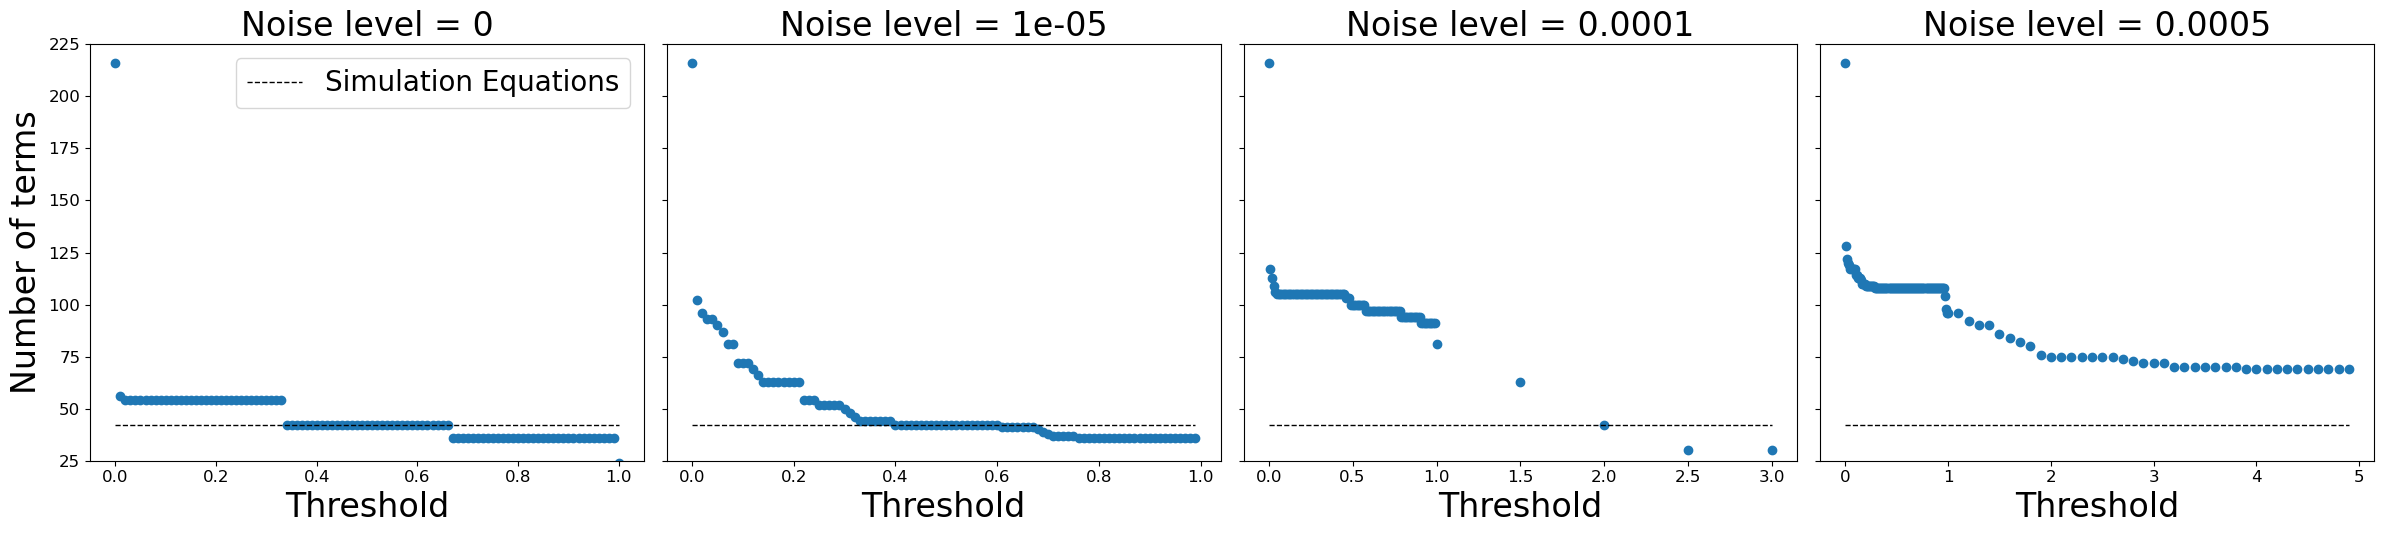

In [12]:
heading_fontsize = 24
noise_models = [nonoise_models,noise00001_models, noise00010_models, noise00050_models]#, noise00003_models, noise00004_models]
noise_levels = [0, 1e-5, 1e-4, 5e-4]
figsize = (24,5.5)
plt.rcParams['font.size'] = 12
fig, axs = plt.subplots(1, len(noise_models), sharey=True,figsize=figsize)
for i, model_list in enumerate(noise_models):
    # extract hparams and complexity from each model
    thresholds = np.array([model.optimizer.threshold for model in model_list])
    complexities = np.array([model.complexity for model in model_list])
    # plot complexity vs. thresholds
    axs[i].plot(thresholds, complexities, 'o')
    axs[i].set_title('Noise level = ' + str(noise_levels[i]), fontsize=heading_fontsize)
    axs[i].set_ylim(25,225)
    axs[i].set_xlabel('Threshold', fontsize=heading_fontsize)
    axs[i].hlines(42, 0, np.max(thresholds), colors='k', linestyles='dashed', lw=1, label="Simulation Equations")
axs[0].legend(fontsize=heading_fontsize-4)
axs[0].set_ylabel('Number of terms', fontsize=heading_fontsize)
fig.tight_layout()
fig.show()

In [ ]:
heading_fontsize = 24
noise_models = [nonoise_models,noise00001_models, noise00010_models, noise00050_models]#, noise00003_models, noise00004_models]
noise_levels = [0, 1e-5, 1e-4, 5e-4]
figsize = (12,10)
plt.rcParams['font.size'] = 12
fig, axs = plt.subplots(2,2, sharey=True,figsize=figsize)
axs.resize(4,)
for i, model_list in enumerate(noise_models):
    # extract hparams and complexity from each model
    thresholds = np.array([model.optimizer.threshold for model in model_list])
    complexities = np.array([model.complexity for model in model_list])
    # plot complexity vs. thresholds
    axs[i].plot(thresholds, complexities, 'o')
    axs[i].set_title('Noise level = ' + str(noise_levels[i]), fontsize=heading_fontsize)
    axs[i].set_ylim(25,225)
    axs[i].set_xlabel('Threshold', fontsize=heading_fontsize)
    axs[i].hlines(42, 0, np.max(thresholds), colors='k', linestyles='dashed', lw=1, label="Simulation Equations")
axs[0].legend(fontsize=heading_fontsize-4)
axs[0].set_ylabel('Number of terms', fontsize=heading_fontsize)
fig.tight_layout()
fig.show()

In [ ]:
figsize = (6,4.5)
label_fontsize = 18
noise_level = 0.0005
fig, axs = plt.subplots(1, 1, sharex=True,figsize=figsize)
# extract hparams and complexity from each model
thresholds = np.array([model.optimizer.threshold for model in noise00050_models])
complexities = np.array([model.complexity for model in noise00050_models])
# plot complexity vs. thresholds
axs.plot(thresholds, complexities, '.')
axs.set_ylabel('Number of terms', fontsize=label_fontsize)
axs.set_title('Noise level = ' + str(noise_level), fontsize=label_fontsize)
axs.set_ylim(25,225)
axs.set_xlabel('Threshold', fontsize=label_fontsize)
fig.tight_layout()
fig.show()

In [ ]:
len(nonoise_models[0].get_feature_names())

In [ ]:
nonoise_models[0].get_feature_names()

### Images for committee update

In [90]:
for sim in sim_list:
    # delete noise if present
    if sim.is_noisy:
        sim.delete_noise()
    # subtract data and add noise
    if sim.is_subtracted:
        sim.unsubtract_data()

In [91]:
# sanity checks to see if noise was added, how many sims there are, and whether data was actually subtracted
print("data is noisy:", sim_list[0].is_noisy)
print("number of sims:", len(sim_list))
print("data is subtracted:", sim_list[0].is_subtracted)

data is noisy: False
number of sims: 200
data is subtracted: False


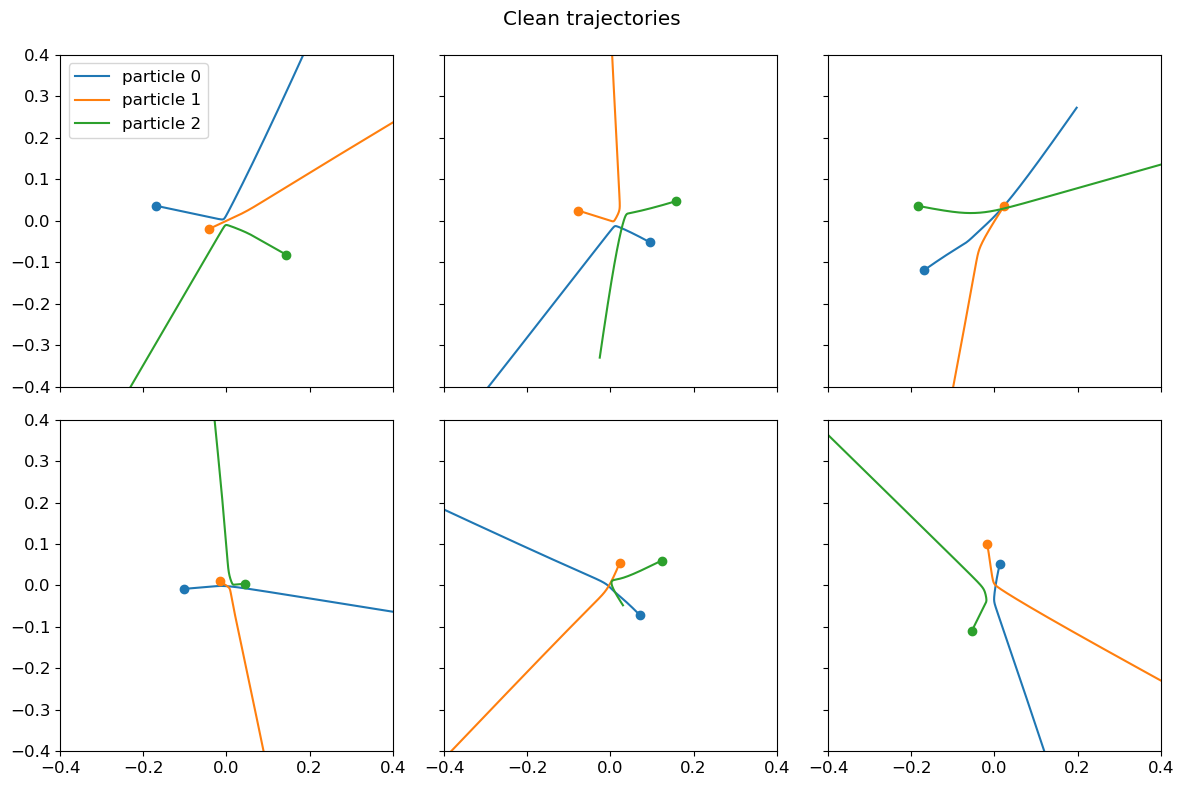

In [92]:
fig, axs =y3.plot_multiple(sim_list,6)
fig.suptitle("Clean trajectories")
fig.tight_layout()

In [86]:
# Process data from simulation objects in place: subtract data and add noise
noise_level = 0
for sim in sim_list:
    # subtract data and add noise
    if not sim.is_subtracted:
        sim.subtract_data()
    if sim.is_noisy:
        sim.delete_noise()
    if noise_level!=0:
        sim.add_gaussian_noise(noise_level=noise_level)

In [87]:
# sanity checks to see if noise was added, how many sims there are, and whether data was actually subtracted
print("data is noisy:", sim_list[0].is_noisy)
print("noise level:", sim_list[0].noise_level)
print("number of sims:", len(sim_list))
print("data is subtracted:", sim_list[0].is_subtracted)

data is noisy: False
noise level: 0
number of sims: 200
data is subtracted: True


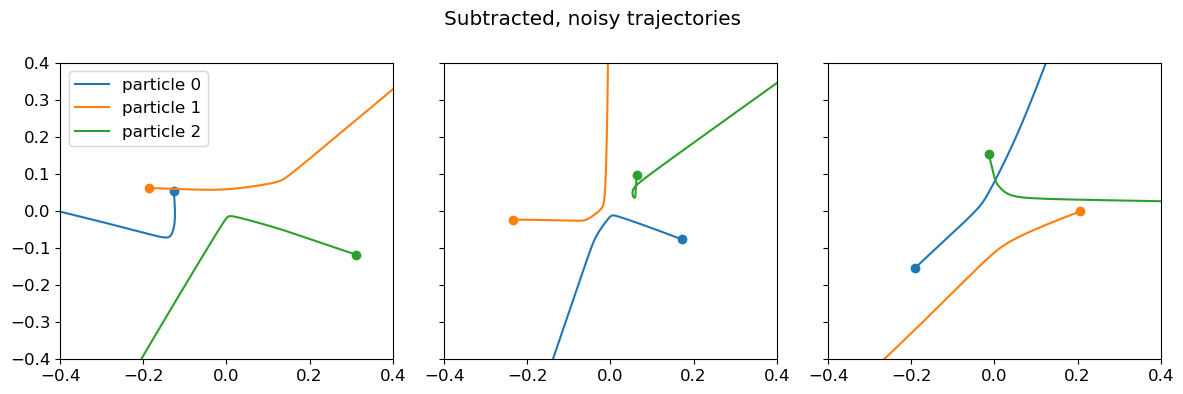

In [ ]:
fig, axs = y3.plot_multiple(sim_list,3)
fig.suptitle("Subtracted trajectories")
fig.tight_layout()

## Weak-form SINDy

### `noise_level=0`

In [94]:
weak_nonoise_models = y3.load_SINDy_models('data/weak_noisy/SINDy_results/noise_0.00000/model_objs')

First, as a sanity check, let's make sure we are using the library of terms that we want even in the weak case.

In [95]:
weak_nonoise_models[0].get_feature_names()

['vx0-vx1',
 'vy0-vy1',
 'vx1-vx2',
 'vy1-vy2',
 'vx2-vx0',
 'vy2-vy0',
 '(x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)',
 '(y0-y1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)',
 '(x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)^(3/2)',
 '(y0-y1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)^(3/2)',
 '(x1-x2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)',
 '(y1-y2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)',
 '(x1-x2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)^(3/2)',
 '(y1-y2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)^(3/2)',
 '(x2-x0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)',
 '(y2-y0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)',
 '(x2-x0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)^(3/2)',
 '(y2-y0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)^(3/2)']

In [96]:
len(weak_nonoise_models[0].get_feature_names())

18

Text(0.5, 1.0, 'Noise level = 0')

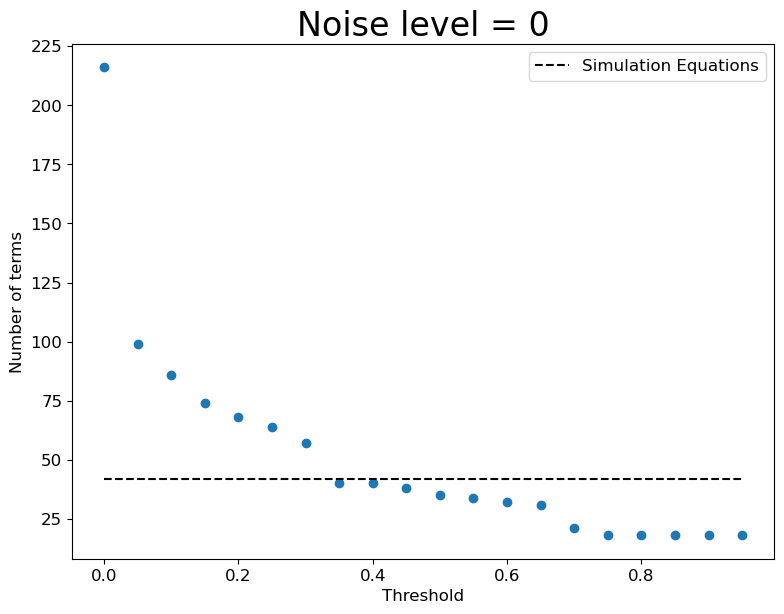

In [101]:
fig, ax = ys.plot_complexity_objs(weak_nonoise_models)
ax.set_title("Noise level = 0", fontsize=24)

In [39]:
for i in [6,7]:
    y3.print_SINDy_nice(weak_nonoise_models[i], sim_list)

noise level: 0
number of trajectories: 200
STLSQ threshold: 0.30000000000000004
complexity: 57
(x0-x1)'      = -0.297 vx0-vx1
              + -1.297 vx1-vx2
              + -1.297 vx2-vx0

(vx0-vx1)'    = -179210114359540.500 vy0-vy1
              + 0.719 vx1-vx2
              + -179210114359540.500 vy1-vy2
              + -179210114359541.531 vy2-vy0
              + 6.030 (x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)
              + -4.956 (x1-x2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)
              + -4.649 (x2-x0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)
              + 0.873 (y2-y0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)

(y0-y1)'      = 4.874 vy0-vy1
              + 3.874 vy1-vy2
              + 3.874 vy2-vy0

(vy0-vy1)'    = 0.812 vx0-vx1
              + -0.770 vy0-vy1
              + -0.416 vx2-vx0
              + 6.807 (y0-y1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)
              + -3.3

We can see here that the trivial equations are discovered between threshold values of 0.30 and 0.35, but that the interesting equations are already chopping off important terms. Further, we can see that in the case of threshold=0.35, the cartesian indices of the features on the LHS of equations in general do not correspond to those on the RHS. This is a significant decrease in performance from strong SINDy, which generally correlates the indices even when discovering extraneous terms.

The next step would be to investigate exactly why this is happening, and to investigate whether it can be fixed by tweaking the parameters of the weak SINDy library via the arguments of `pysindy.WeakPDELibrary`. Some arguments which can be tweaked to perhaps improve upon these results include:
- `K`: "Number of domain centers, corresponding to subdomain squares of length `Hxt`. If `K` is not specified, defaults to 100."
- `Hxt`: Size of the integration domain in each spatiotemporal direction. Set to `L_xt` by default, where `L_xt` is the size of the full computational domain.
- Sparse regularizer: maybe the use of STLSQ in this case yields bad results, could be worth looking into something like SR3.

### `noise_level=1e-5`

### `noise_level=1e-4`

### `noise_level=5e-4`

In [ ]:
# load in SINDy models for 5e-4 noise case
weak_noise00050_models = y3.load_SINDy_models('data/weak_noisy/SINDy_results/noise_0.00050/model_objs')

In [6]:
# remove models with threshold > 1
weak_noise00050_models_to1 = [model for model in weak_noise00050_models if model.optimizer.threshold <= 1]

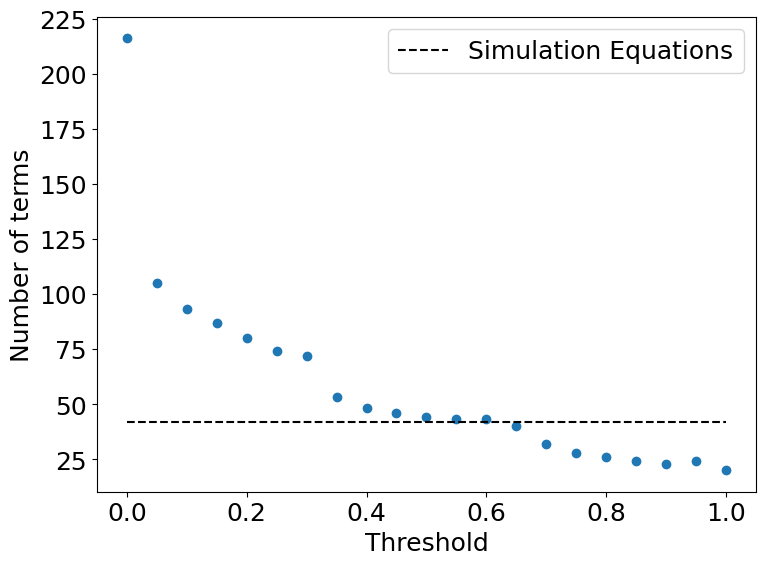

In [21]:
fig, ax = ys.plot_complexity_objs(weak_noise00050_models_to1)
# plot a line at the "correct" number of terms
ax.hlines(42, 0, 1.0, colors='k', linestyles='dashed', lw=1.5, label="Simulation Equations")
ax.legend()

In [22]:
len(weak_noise00050_models_to1)

21

In [25]:
weak_noise00050_models_to1[11].optimizer.threshold

0.55

In [30]:
for i in [6,7,8]:
    y3.print_SINDy_nice(weak_noise00050_models_to1[i], sim_list)

noise level: 0
number of trajectories: 200
STLSQ threshold: 0.30000000000000004
complexity: 72
(x0-x1)'      = -17.504 vx0-vx1
              + -18.504 vx1-vx2
              + -18.504 vx2-vx0

(vx0-vx1)'    = -0.658 vx0-vx1
              + 47680.080 vy0-vy1
              + 0.827 vx1-vx2
              + 47680.037 vy1-vy2
              + 47678.809 vy2-vy0
              + 17.699 (x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)
              + 0.606 (y0-y1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)
              + -11.616 (x1-x2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)
              + 0.342 (y1-y2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)
              + -9.995 (x2-x0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)
              + 0.432 (y2-y0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)

(y0-y1)'      = 7.196 vy0-vy1
              + 6.196 vy1-vy2
              + 6.196 vy2-vy0

(vy0-vy1)'    = 1.068

In [27]:
for i in [12,13,14]:
    y3.print_SINDy_nice(weak_noise00050_models_to1[i], sim_list)

noise level: 0
number of trajectories: 200
STLSQ threshold: 0.6000000000000001
complexity: 43
(x0-x1)'      = 1.000 vx0-vx1

(vx0-vx1)'    = -0.659 vx0-vx1
              + 0.826 vx1-vx2
              + -1.255 vy2-vy0
              + 17.697 (x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)
              + -11.618 (x1-x2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)
              + -9.958 (x2-x0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)

(y0-y1)'      = 1.000 vy0-vy1

(vy0-vy1)'    = 1.088 vx0-vx1
              + -1.581 vy0-vy1
              + -1.148 (x0-x1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)
              + 18.320 (y0-y1) exp( -sqrt((x0-x1)^2+(y0-y1)^2) ) / ((x0-x1)^2+(y0-y1)^2)
              + -8.947 (y1-y2) exp( -sqrt((x1-x2)^2+(y1-y2)^2) ) / ((x1-x2)^2+(y1-y2)^2)
              + -0.857 (x2-x0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) / ((x2-x0)^2+(y2-y0)^2)
              + -8.725 (y2-y0) exp( -sqrt((x2-x0)^2+(y2-y0)^2) ) /

### `noise_level=1e-3`

In [15]:
# load in SINDy models for 1e-3 noise case
weak_noise00100_models = y3.load_SINDy_models('data/weak_noisy/SINDy_results/noise_0.00100/model_objs')
# remove models with threshold > 1
weak_noise00100_models_to1 = [model for model in weak_noise00100_models if model.optimizer.threshold <= 1]

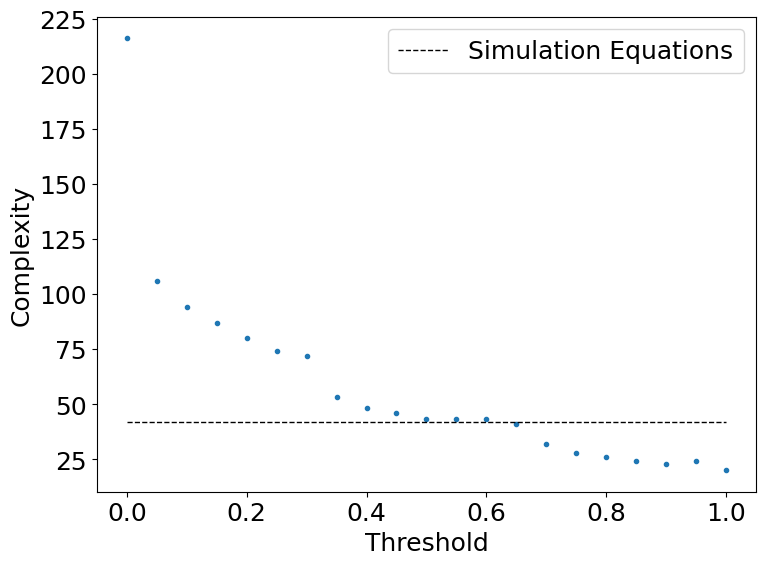

In [16]:
fig, ax = ys.plot_complexity_objs(weak_noise00100_models_to1)
ax.hlines(42, 0, 1.0, colors='k', linestyles='dashed', lw=1, label="Simulation Equations")
ax.legend()